# Data science take-home assignment

### Overview
The objective of this assignment is to create a model that predicts the likelihood that a patient will have a hospital admission in the next 180 days. This assignment gives the candidate the opportunity to demonstrate their data wrangling, feature engineering and model building capabilities.

It is strongly recommended that the output of this assignment be a well structured jupyter notebook. Pandas and Sklearn are recommended, but not required. If you want to prototype in Matlab, R or Excel, feel free to do so. If that is the case, a transformed jupyter notebook or source code plus write-up can help us post-process the results.

**The minimum model performance metrics that must be reported are the model’s ROC AUC and precision-recall curve AUC.**

### Data Dictionary
All patient data has been de-identified and event dates have been replaced with days until prediction.

TO DO:
- predict likelihood that pt will have hospital admission in next 180 days

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### patient data ###
prediction_obj = pd.read_csv('patient_data/prediction_objective.csv')
demographics = pd.read_csv('patient_data/demographics.csv')
medications = pd.read_csv('patient_data/medications.csv')
claims = pd.read_csv('patient_data/claims.csv')
diagnosis = pd.read_csv('patient_data/diagnosis.csv')

### reference data ###
atc_crosswalk = pd.read_csv('reference_data/atc_crosswalk.csv')
ccs_crosswalk = pd.read_csv('reference_data/ccs_crosswalk.csv')

## Data Exploration

In [3]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [4]:
# "prediction_obj" data
print(prediction_obj.columns)
print('')
prediction_obj.info()
print('')
print('Number of patients:', len(prediction_obj))
print(f'Prevalence:', calc_prevalence(prediction_obj['HAS_ADMISSION'].values))
print('Number of patients with admission:', len(prediction_obj[prediction_obj['HAS_ADMISSION']==1]))

Index(['PATIENT_ID', 'HAS_ADMISSION'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   PATIENT_ID     100000 non-null  int64
 1   HAS_ADMISSION  100000 non-null  int64
dtypes: int64(2)
memory usage: 1.5 MB

Number of patients: 100000
Prevalence: 0.0459
Number of patients with admission: 4590


**"prediction_obj" dataset**
- There are no non-values (NaNs) in the dataset. Not dropping any rows.
- Around 4.6% of the population has admission. This represents a class imbalance, which may be a problem when feeding into a predictive model (because model will be biased towards the majority class). 

Index(['PATIENT_ID', 'SEX', 'AGE'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PATIENT_ID  100000 non-null  int64 
 1   SEX         100000 non-null  object
 2   AGE         100000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


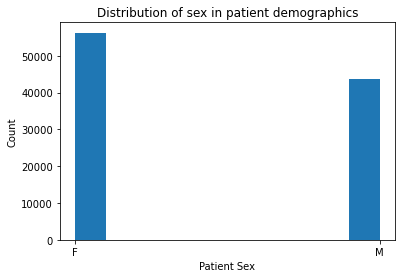

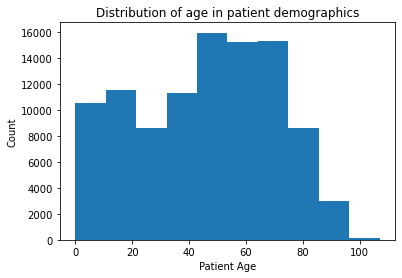

In [5]:
# "demographics" data
print(demographics.columns)
print('')
demographics.info()

plt.hist(demographics["SEX"])
plt.title("Distribution of sex in patient demographics")
plt.xlabel("Patient Sex")
plt.ylabel("Count")
plt.show()

plt.hist(demographics["AGE"])
plt.title("Distribution of age in patient demographics")
plt.xlabel("Patient Age")
plt.ylabel("Count")
plt.show()

**"demographics" dataset**
- There are no non-values (NaNs) in the dataset. Not dropping any rows. 
- quick glance at SEX column, seems like Female:Male ratio is skewed towards Females. However, not huge imbalance. May need to re-balance later before feeding into model.
- quick glance at AGE column, seems like distribution is somewhat normal, but right skewed (more patients <20y.o. vs. >80y.o.)

Index(['PATIENT_ID', 'DATESTART', 'MEDICATION_NAME', 'NDC_CODE', 'DOSAGE',
       'DISPENSING_QUANTITY', 'DAYS_SUPPLY', 'ROUTE', 'STRENGTH'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2198090 entries, 0 to 2198089
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   PATIENT_ID           int64  
 1   DATESTART            int64  
 2   MEDICATION_NAME      object 
 3   NDC_CODE             int64  
 4   DOSAGE               float64
 5   DISPENSING_QUANTITY  float64
 6   DAYS_SUPPLY          int64  
 7   ROUTE                object 
 8   STRENGTH             float64
dtypes: float64(3), int64(4), object(2)
memory usage: 150.9+ MB

 MEDICATION_NAME column null values: 94
 DOSAGE column null values: 1781918
 DISPENSING_QUANTITY column null values: 26
 ROUTE column null values: 643897
 STRENGTH column null values: 1781918


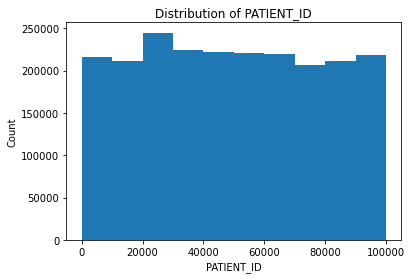

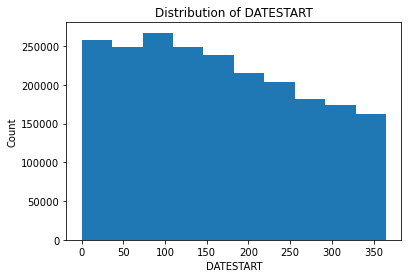

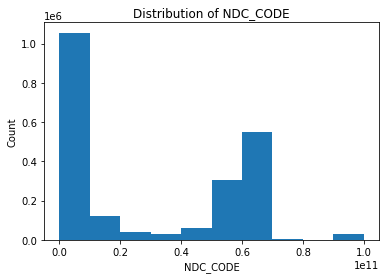

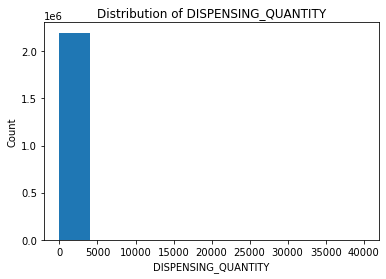

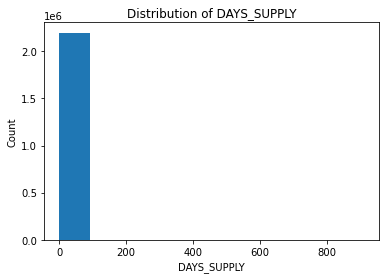

In [6]:
# "medications" data
print(medications.columns)
print('')
medications.info()
print('')

for col in medications.columns:
    col_null_sum = medications[col].isnull().sum()
    if col_null_sum != 0:
        print(f'', col, 'column null values:', col_null_sum)

new_medications_cols = [x for x in medications.columns 
                        if x not in("DOSAGE", "STRENGTH", "ROUTE")]
for col in new_medications_cols:
    if col not in ("MEDICATION_NAME"):
        plt.hist(medications[col])
        plt.title('Distribution of '+col)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

**"medications" dataset**
- There are 2,198,090 rows while this dataset only has 100,000 patients -- meaning that patients may have multiple different prescribed medications. 
- DOSAGE and STRENGTH columns have over 1 million null values, and ROUTE column has over 600,000 null values. Due to large null values which represent data incompleteness, will dropping these columns from analysis. Large data incompleteness may introduce noise in ML model.
- NCD_CODE histogram not normally distributed but ok because represents national drug code, which is categorical.
- DISPENSING_QUANTITY and DAYS_SUPPLY histograms super right skewed, looks like there may be outlier(s). The outliers don't look too abnormal -- **ask whether the outliers may be input errors**, but include them in analysis for now. 

Index(['PATIENT_ID', 'CLAIM_ID', 'ADMISSION_DATE', 'DISCHARGE_DATE',
       'DRG_CODE', 'REVENUE_CODE', 'CPT_CODE', 'PLACE_OF_SERVICE'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3175892 entries, 0 to 3175891
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   PATIENT_ID        int64  
 1   CLAIM_ID          object 
 2   ADMISSION_DATE    int64  
 3   DISCHARGE_DATE    float64
 4   DRG_CODE          float64
 5   REVENUE_CODE      float64
 6   CPT_CODE          object 
 7   PLACE_OF_SERVICE  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 193.8+ MB

 DISCHARGE_DATE column null values: 470071
 DRG_CODE column null values: 3059566
 REVENUE_CODE column null values: 2689603
 CPT_CODE column null values: 166380


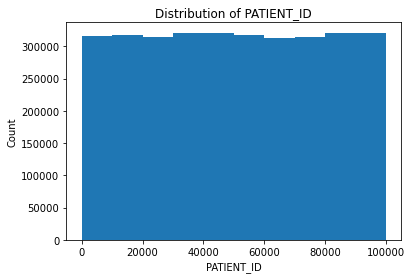

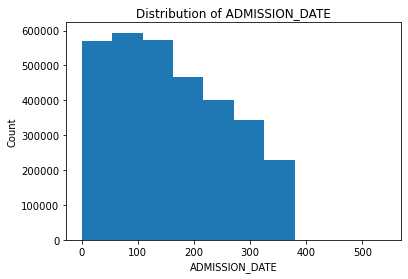

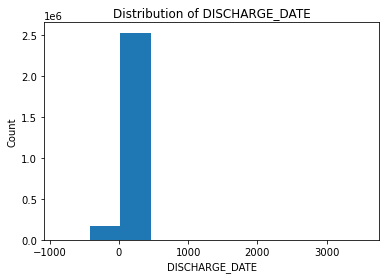

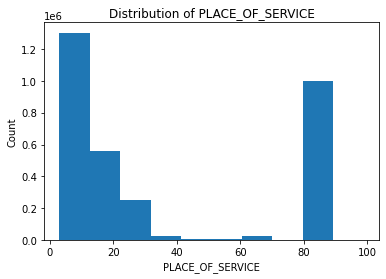

In [7]:
# "claims" data
print(claims.columns)
print('')
claims.info()
print('')

for col in claims.columns:
    col_null_sum = claims[col].isnull().sum()
    if col_null_sum != 0:
        print(f'', col, 'column null values:', col_null_sum)
        
new_claims_cols = [x for x in claims.columns if x not in("DRG_CODE", "REVENUE_CODE")]
for col in new_claims_cols:
    if col not in ("CLAIM_ID", "CPT_CODE"):
        plt.hist(claims[col])
        plt.title('Distribution of '+col)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

**"claims" dataset**
- There are 3,175,892 rows.
- DRG_CODE has over 3 million null values, and REVENUE_CODE has over 2.6 million. These columns will be dropped due to data incompleteness. DISCHARGE_DATE and CPT_CODE have less than 500,000 null values, so will be kept in the analysis. 
- CLAIM_ID drop from analysis because each row is a new claim ID ?
- CPT_CODE no histogram because codes are a mix of letters + numbers ... use bar chart to visualize data? 
- negative DISCHARGE_DATE?? 
- may need to create a new column that calculated difference between ADMISSION_DATE and DISCHARGE_DATE

Index(['CLAIM_ID', 'PRIORITY', 'CODE_TYPE', 'CODE', 'CODE_DESCRIPTION'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2809365 entries, 0 to 2809364
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   CLAIM_ID          object
 1   PRIORITY          int64 
 2   CODE_TYPE         object
 3   CODE              object
 4   CODE_DESCRIPTION  object
dtypes: int64(1), object(4)
memory usage: 107.2+ MB

 CODE_DESCRIPTION column null values: 77


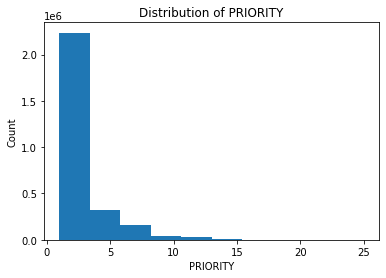

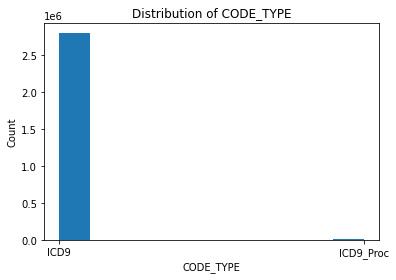

In [8]:
# "diagnosis" data

print(diagnosis.columns)
print('')
diagnosis.info()
print('')

for col in diagnosis.columns:
    col_null_sum = diagnosis[col].isnull().sum()
    if col_null_sum != 0:
        print(f'', col, 'column null values:', col_null_sum)

new_diagnosis_cols = [x for x in diagnosis.columns if x not in("CLAIM_ID", "CODE_DESCRIPTION", "CODE")]
for col in new_diagnosis_cols:
    plt.hist(diagnosis[col])
    plt.title('Distribution of '+col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

**"diagnosis" dataset**
- CLAIM_ID most likely unique for each row, and CODE_DESCRIPTION irrelevant to predicting hospital admission. Drop both columns from analysis.
- can use CODE_DESCRIPTION later on if using NLP (eg., BERT) to parse through the descriptions to find patterns
- need bar chart for CODE ?
- may want to use CODE and not CODE_TYPE, because CODE more unique whereas there are only 2 ICD CODE_TYPE in this dataset

## Feature Engineering
Create features for the predictive model. End result: new columns with features we want for the model will be added to a new dataframe. 

**only work with columns we want**
(Reference PDF to see justification for column selection)

*prediction_objective.csv*
- PATIENT_ID
- HAS_ADMISSION

*demographics.csv*
- PATIENT_ID
- SEX (have to one-hot encode) 
- AGE

*medications.csv*
- PATIENT_ID
- DATESTART
- NDC_CODE (map to ATC_code) 

*claims.csv*
- PATIENT_ID
- CLAIM_ID
- ADMISSION_DATE
- PLACE_OF_SERVICE (have to one-hot encode)

*diagnosis.csv*
- CLAIM_ID
- PRIORITY (group + one-hot encode) 
- CODE (map to CCS_code) 

*atc_crosswalk.csv, ccs_crosswalk.csv*

In [9]:
pred_df = prediction_obj[['PATIENT_ID', 'HAS_ADMISSION']]
dem_df = demographics[['PATIENT_ID', 'SEX', 'AGE']]
med_df = medications[['PATIENT_ID', 'DATESTART', 'NDC_CODE']]
claim_df = claims[['PATIENT_ID', 'CLAIM_ID', 'ADMISSION_DATE', 'PLACE_OF_SERVICE']]
diag_df = diagnosis[['CLAIM_ID', 'PRIORITY', 'CODE']]

medications df: **map medications.csv NDC_CODE --> atc_crosswalk.csv ATC numbers**

In [10]:
atc_crosswalk = atc_crosswalk.astype({"ATC":'string', "ATC_LABEL":'string'})
atc_crosswalk.dtypes

NDC          object
ATC          string
ATC_LABEL    string
dtype: object

In [11]:
atc_crosswalk[['NDC']] = atc_crosswalk[['NDC']].apply(pd.to_numeric, errors='coerce')
atc_crosswalk.dtypes

NDC          float64
ATC           string
ATC_LABEL     string
dtype: object

In [12]:
# there are 757 null (ie. contains letters in the NDC code) values
# will drop these from analysis
print(f'Number of null NDC codes:', atc_crosswalk['NDC'].isnull().sum())
print(f'Previous atc_crosswalk df shape:', atc_crosswalk.shape)
atc_1 = atc_crosswalk.dropna()
print(f'New (dropped) atc_crosswalk df shape:', atc_1.shape)

#atc_1[['NDC']] = atc_1[['NDC']].astype(int)
#atc_1.dtypes

mapping = dict(atc_1[['NDC','ATC']].values)
med_df['ATC_code'] = med_df.NDC_CODE.map(mapping)
med_df = med_df.drop('NDC_CODE', axis=1) # NDC codes no longer needed
med_df.head()

Number of null NDC codes: 757
Previous atc_crosswalk df shape: (1844783, 3)
New (dropped) atc_crosswalk df shape: (1844026, 3)


/var/folders/vl/j3jtwcfn5n1d4dwn0jdsmv880000gp/T/ipykernel_905/2633572640.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med_df['ATC_code'] = med_df.NDC_CODE.map(mapping)


,PATIENT_ID,DATESTART,ATC_code
0,98790,145,N03AX12
1,90595,98,C03AA03
2,59974,307,A02BC01
3,57910,58,P03AX05
4,98790,286,N02AA05


In [13]:
print(med_df.shape) # same number of rows as original medications df
print(f'Number of null ATC_code(s):', med_df['ATC_code'].isnull().sum())

(2198090, 3)
Number of null ATC_code(s): 78134


diagnosis df: **map diagnosis.csv diagnosis code (CODE) numbers -->  ccs_crosswalk.csv CCS code (diag_code -> ccs_code)**

In [14]:
ccs_crosswalk['diag_code'] = ccs_crosswalk['diag_code'].replace('_', '.', regex=True)

mapping_2 = dict(ccs_crosswalk[['diag_code', 'ccs_code']].values)
diag_df['CCS_code'] = diag_df.CODE.map(mapping_2)
diag_df = diag_df.drop('CODE', axis=1) # diagnosis CODE no longer needed
diag_df.head()

/var/folders/vl/j3jtwcfn5n1d4dwn0jdsmv880000gp/T/ipykernel_905/1259761944.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diag_df['CCS_code'] = diag_df.CODE.map(mapping_2)


,CLAIM_ID,PRIORITY,CCS_code
0,A106686371,4,49.0
1,A112336349,6,101.0
2,A12060184251289,16,54.0
3,A106226016,5,NaN
4,A100457749,1,133.0


In [15]:
# there are certain diagnosis codes (in diagnosis.csv) that do not exist in the ccs_crosswalk.csv
ccs_crosswalk[ccs_crosswalk['diag_code'] == '338.29'] # example 
# so there are NaNs in the new CCS_code column
print(f'Number of null CCS_code(s):', diag_df['CCS_code'].isnull().sum())
# but, there are same number of rows as original diagnosis df
print(diag_df.shape)

Number of null CCS_code(s): 329119
(2809365, 3)


**merge prediction_objective + demographics on PATIENT_ID**

In [16]:
# pt_df
pt_df = pred_df.merge(dem_df, how='left', on='PATIENT_ID')
print(pt_df.shape)
pt_df.head()

(100000, 4)


,PATIENT_ID,HAS_ADMISSION,SEX,AGE
0,0,0,F,6
1,1,0,F,53
2,2,0,F,68
3,3,0,M,76
4,4,0,M,73


***TO DO***
- SEX one-hot encode

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer((OneHotEncoder(), ['SEX']), 
                                     remainder='passthrough')

transformed = transformer.fit_transform(pt_df)
transformed_pt_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)

In [18]:
transformed_pt_df.rename(columns={'onehotencoder__x0_F': 'SEX_F', 
                                  'onehotencoder__x0_M': 'SEX_M'}, inplace=True)
transformed_pt_df.head()

,SEX_F,SEX_M,PATIENT_ID,HAS_ADMISSION,AGE
0,1.0,0.0,0.0,0.0,6.0
1,1.0,0.0,1.0,0.0,53.0
2,1.0,0.0,2.0,0.0,68.0
3,0.0,1.0,3.0,0.0,76.0
4,0.0,1.0,4.0,0.0,73.0


# use transformed_pt_df  !!

**merge claims + diagnosis on CLAIM_ID**

In [19]:
# diag_claim_df
diag_claim_df = claim_df.merge(diag_df, how='outer', on='CLAIM_ID')
print(diag_claim_df.shape)
diag_claim_df

(9585423, 6)


,PATIENT_ID,CLAIM_ID,ADMISSION_DATE,PLACE_OF_SERVICE,PRIORITY,CCS_code
0,50392,A42024972,299,23,1.0,205.0
1,50392,A42024972,299,23,4.0,48.0
2,50392,A42024972,299,23,2.0,98.0
3,50392,A42024972,299,23,3.0,106.0
4,50392,A42024972,299,23,1.0,205.0
...,...,...,...,...,...,...
9585418,38048,B54784753,169,12,3.0,95.0
9585419,38048,B54784753,169,12,1.0,199.0
9585420,38048,B54784753,169,12,2.0,199.0
9585421,99403,B89875090,224,12,1.0,NaN


Looking at different CLAIM_ID values shows that each claim ID has same patient ID, admission date, and place of service. The only differing factors are priority and CCS code. 

curious if we can group or see trends in the CCS_code, because one-hot encoding all the CCS codes introduce a lot of variables

<AxesSubplot:>

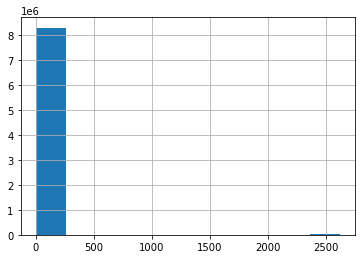

In [20]:
# look at histogram of CCS_code
diag_claim_df['CCS_code'].hist()

In [21]:
# there are only 280 ccs code categories
# drop all ccs codes that are greater than 280 
# ASK: are these errors? 
dc_df = diag_claim_df.drop(index=diag_claim_df[diag_claim_df['CCS_code'] > 280].index)
dc_df.shape

(9547890, 6)

<AxesSubplot:>

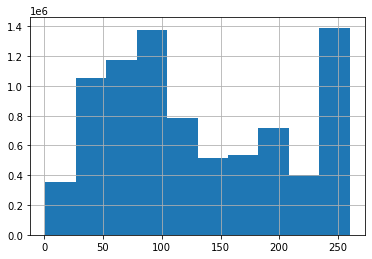

In [22]:
# look at new df histogram of CCS_code
dc_df['CCS_code'].hist()

We could group by doing top 10 CCS codes, but that may reduce a lot of the data, so deciding to one-hot encode.

***TO DO***
- CCS_code one-hot encode
- PLACE_OF_SERVICE one-hot encode
- PRIORITY group + one-hot encode
- ADMISSION_DATE group + one-hot encode

In [23]:
## group PRIORITY column ##
print('Number of priorities:', dc_df.PRIORITY.nunique())
dc_df.groupby('PRIORITY').size().sort_values(ascending=False)

Number of priorities: 25


PRIORITY
1.0     3261706
2.0     1946174
3.0     1296767
4.0      895516
5.0      469162
6.0      375713
7.0      294877
8.0      242165
9.0      186488
10.0     151268
11.0     124240
12.0      99839
13.0      48123
14.0      38145
15.0      31709
16.0      25769
17.0      20306
18.0      16875
19.0       6531
20.0       4653
21.0       3805
22.0       2943
23.0       2373
24.0       1600
25.0       1142
dtype: int64

Looks like the top 5 highest priorities have the most data points, which may indicate higher significance. So, will create 6 options (the top 5 priorities and a 6-25 priority column).

In [24]:
top_5 = np.arange(1,6).tolist()
print(top_5)

[1, 2, 3, 4, 5]


In [25]:
# make a new column with duplicated data
dc_df['priority'] = dc_df['PRIORITY'].copy()

# replace all priorities not in top 10 with '11-25' category
dc_df.loc[~dc_df.priority.isin(top_5),'priority'] = '6-25'

# drop the original PRIORITY column 
dc_df = dc_df.drop(columns='PRIORITY')

In [26]:
dc_df.groupby('priority').size()

priority
1.0     3261706
2.0     1946174
3.0     1296767
4.0      895516
5.0      469162
6-25    1678565
dtype: int64

<AxesSubplot:>

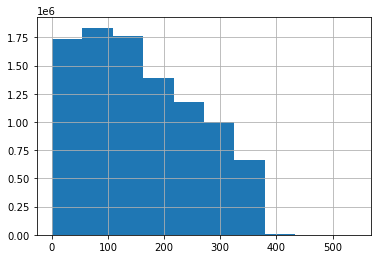

In [27]:
## group ADMISSION_DATE column ##
dc_df['ADMISSION_DATE'].hist()
# group ADMISSION_DATE by 100 days? (can change around later--fine tune)

In [28]:
bins = pd.interval_range(start=0, end=600, periods=6)
#bin_labels = ['0-99', '100-199', '200-299', '300-399', '400-499', '500-600']

dc_df['ADMISSION_DATE_bin_cut'] = pd.cut(dc_df['ADMISSION_DATE'], 
                                       bins=bins)

dc_df['ADMISSION_DATE_bin_cut'].value_counts()

(0, 100]      3254412
(100, 200]    3057193
(200, 300]    2119403
(300, 400]    1092159
(400, 500]        761
(500, 600]         14
Name: ADMISSION_DATE_bin_cut, dtype: int64

In [29]:
dc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9547890 entries, 0 to 9585422
Data columns (total 7 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   PATIENT_ID              int64   
 1   CLAIM_ID                object  
 2   ADMISSION_DATE          int64   
 3   PLACE_OF_SERVICE        int64   
 4   CCS_code                float64 
 5   priority                object  
 6   ADMISSION_DATE_bin_cut  category
dtypes: category(1), float64(1), int64(3), object(2)
memory usage: 519.0+ MB


In [30]:
# drop CLAIM_ID column, because not needed (irrelevant) now.
dc_df = dc_df.drop(columns='CLAIM_ID')
# drop ADMISSION_DATE column, because data captured in ADMISSION_DATE_bin_cut now.
dc_df = dc_df.drop(columns='ADMISSION_DATE')

In [31]:
# convert numerical data into strings to create one-hot encodings 
# for the 4 columns: priority, CCS_code, PLACE_OF_SERVICE, ADMISSION_DATE_bin_cut
cols_to_convert = ['priority', 'CCS_code', 'PLACE_OF_SERVICE', 'ADMISSION_DATE_bin_cut']
dc_df[cols_to_convert] = dc_df[cols_to_convert].astype('str')

In [32]:
# one-hot encode the 4 columns
transformer = make_column_transformer((OneHotEncoder(), ['priority', 'CCS_code', 'PLACE_OF_SERVICE', 'ADMISSION_DATE_bin_cut']), 
                                     remainder='passthrough')

transformed = transformer.fit_transform(dc_df)
transformed_dc_df = pd.DataFrame.sparse.from_spmatrix(
    transformed, 
    columns=transformer.get_feature_names()
)
transformed_dc_df.head()

,onehotencoder__x0_1.0,onehotencoder__x0_2.0,onehotencoder__x0_3.0,onehotencoder__x0_4.0,onehotencoder__x0_5.0,onehotencoder__x0_6-25,onehotencoder__x1_1.0,onehotencoder__x1_10.0,onehotencoder__x1_100.0,onehotencoder__x1_101.0,...,onehotencoder__x2_98,onehotencoder__x2_99,"onehotencoder__x3_(0, 100]","onehotencoder__x3_(100, 200]","onehotencoder__x3_(200, 300]","onehotencoder__x3_(300, 400]","onehotencoder__x3_(400, 500]","onehotencoder__x3_(500, 600]",onehotencoder__x3_nan,PATIENT_ID
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0


In [33]:
list(transformed_dc_df.columns)

['onehotencoder__x0_1.0',
 'onehotencoder__x0_2.0',
 'onehotencoder__x0_3.0',
 'onehotencoder__x0_4.0',
 'onehotencoder__x0_5.0',
 'onehotencoder__x0_6-25',
 'onehotencoder__x1_1.0',
 'onehotencoder__x1_10.0',
 'onehotencoder__x1_100.0',
 'onehotencoder__x1_101.0',
 'onehotencoder__x1_102.0',
 'onehotencoder__x1_103.0',
 'onehotencoder__x1_104.0',
 'onehotencoder__x1_105.0',
 'onehotencoder__x1_106.0',
 'onehotencoder__x1_107.0',
 'onehotencoder__x1_108.0',
 'onehotencoder__x1_109.0',
 'onehotencoder__x1_11.0',
 'onehotencoder__x1_110.0',
 'onehotencoder__x1_111.0',
 'onehotencoder__x1_112.0',
 'onehotencoder__x1_113.0',
 'onehotencoder__x1_114.0',
 'onehotencoder__x1_115.0',
 'onehotencoder__x1_116.0',
 'onehotencoder__x1_117.0',
 'onehotencoder__x1_118.0',
 'onehotencoder__x1_119.0',
 'onehotencoder__x1_12.0',
 'onehotencoder__x1_120.0',
 'onehotencoder__x1_121.0',
 'onehotencoder__x1_122.0',
 'onehotencoder__x1_123.0',
 'onehotencoder__x1_124.0',
 'onehotencoder__x1_125.0',
 'onehot

In [34]:
# rename the one-hot encoded columns 
transformed_dc_df.columns = transformed_dc_df.columns.str.replace(r"onehotencoder__x0", "priority")
transformed_dc_df.columns = transformed_dc_df.columns.str.replace(r"onehotencoder__x1", "CCS_code")
transformed_dc_df.columns = transformed_dc_df.columns.str.replace(r"onehotencoder__x2", "PLACE_OF_SERVICE")
transformed_dc_df.columns = transformed_dc_df.columns.str.replace(r"onehotencoder__x3", "ADMISSION_DATE_bin_cut")

transformed_dc_df.head()

,priority_1.0,priority_2.0,priority_3.0,priority_4.0,priority_5.0,priority_6-25,CCS_code_1.0,CCS_code_10.0,CCS_code_100.0,CCS_code_101.0,...,PLACE_OF_SERVICE_98,PLACE_OF_SERVICE_99,"ADMISSION_DATE_bin_cut_(0, 100]","ADMISSION_DATE_bin_cut_(100, 200]","ADMISSION_DATE_bin_cut_(200, 300]","ADMISSION_DATE_bin_cut_(300, 400]","ADMISSION_DATE_bin_cut_(400, 500]","ADMISSION_DATE_bin_cut_(500, 600]",ADMISSION_DATE_bin_cut_nan,PATIENT_ID
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0


In [35]:
# ADMISSION_DATE_bin_cut_nan represents admission date 0, so rename
transformed_dc_df.columns = transformed_dc_df.columns.str.replace(r"nan", "0")
transformed_dc_df.head()

,priority_1.0,priority_2.0,priority_3.0,priority_4.0,priority_5.0,priority_6-25,CCS_code_1.0,CCS_code_10.0,CCS_code_100.0,CCS_code_101.0,...,PLACE_OF_SERVICE_98,PLACE_OF_SERVICE_99,"ADMISSION_DATE_bin_cut_(0, 100]","ADMISSION_DATE_bin_cut_(100, 200]","ADMISSION_DATE_bin_cut_(200, 300]","ADMISSION_DATE_bin_cut_(300, 400]","ADMISSION_DATE_bin_cut_(400, 500]","ADMISSION_DATE_bin_cut_(500, 600]",ADMISSION_DATE_bin_cut_0,PATIENT_ID
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0


In [40]:
transformed_dc_df

,priority_1.0,priority_2.0,priority_3.0,priority_4.0,priority_5.0,priority_6-25,CCS_code_1.0,CCS_code_10.0,CCS_code_100.0,CCS_code_101.0,...,PLACE_OF_SERVICE_98,PLACE_OF_SERVICE_99,"ADMISSION_DATE_bin_cut_(0, 100]","ADMISSION_DATE_bin_cut_(100, 200]","ADMISSION_DATE_bin_cut_(200, 300]","ADMISSION_DATE_bin_cut_(300, 400]","ADMISSION_DATE_bin_cut_(400, 500]","ADMISSION_DATE_bin_cut_(500, 600]",ADMISSION_DATE_bin_cut_0,PATIENT_ID
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50392.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9547885,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,38048.0
9547886,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,38048.0
9547887,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,38048.0
9547888,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,99403.0


In [41]:
transformed_dc_df.groupby('PATIENT_ID').ADMISSION_DATE_bin_cut_0.agg('sum')

PATIENT_ID
0.0        0.0
1.0        0.0
2.0        0.0
3.0        0.0
4.0        0.0
          ... 
99995.0    0.0
99996.0    0.0
99997.0    0.0
99998.0    0.0
99999.0    0.0
Name: ADMISSION_DATE_bin_cut_0, Length: 99990, dtype: Sparse[float64, 0]

In [42]:
# group and aggregate the data so that each row represents each patient 
#tried, but took too long (over 3+ hours...)

df = transformed_dc_df.groupby('PATIENT_ID').agg('sum')
print(df)

KeyboardInterrupt: 

Therefore, using the transformed_dc_df and transformed_pt_df dataframes for analysis. Each patient has multiple rows.

In [84]:
# merge the two dataframes (transformed_dc_df + transformed_pt_df)
data = transformed_dc_df.merge(transformed_pt_df, how='left', on='PATIENT_ID')
data

,priority_1.0,priority_2.0,priority_3.0,priority_4.0,priority_5.0,priority_6-25,CCS_code_1.0,CCS_code_10.0,CCS_code_100.0,CCS_code_101.0,...,"ADMISSION_DATE_bin_cut_(200, 300]","ADMISSION_DATE_bin_cut_(300, 400]","ADMISSION_DATE_bin_cut_(400, 500]","ADMISSION_DATE_bin_cut_(500, 600]",ADMISSION_DATE_bin_cut_0,PATIENT_ID,SEX_F,SEX_M,HAS_ADMISSION,AGE
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,50392.0,1.0,0.0,0.0,76.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,50392.0,1.0,0.0,0.0,76.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,50392.0,1.0,0.0,0.0,76.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,50392.0,1.0,0.0,0.0,76.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,50392.0,1.0,0.0,0.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9547885,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,38048.0,0.0,1.0,1.0,67.0
9547886,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,38048.0,0.0,1.0,1.0,67.0
9547887,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,38048.0,0.0,1.0,1.0,67.0
9547888,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,99403.0,0.0,1.0,0.0,53.0


## Engineering Features Summary
Total number of features: 
Numerical features:
Categorical features: 

In [85]:
# check if we are missing any data
data.columns.isnull().sum()#.sort_values(ascending=False)

0

## Building train/valid/test samples
70% train, 15% valid, 15% test split

There are 9.5+ million rows. The run time will be too much so sub-setting the data to only the top 100,000 rows for now. 

In [86]:
# not sure if data has some order, so shuffle + select 100,000 rows
sub_data = data.sample(n=100000, random_state=41)
sub_data = sub_data.reset_index(drop=True)

In [87]:
# save 30% of data to use as validation + test data
df_valid_test = sub_data.sample(frac=0.30, random_state=41)

# split test + valid using 50% fraction
df_test = df_valid_test.sample(frac = 0.5, random_state=41)
df_valid = df_valid_test.drop(df_test.index)

# use rest of data as training data
df_train_all = sub_data.drop(df_valid_test.index)

Check prevalence of hospital admission (column HAS_ADMISSION) for train/valid/test samples. Ideally, all three groups should have similar prevalence.

In [88]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.HAS_ADMISSION.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.HAS_ADMISSION.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.HAS_ADMISSION.values)))

Test prevalence(n = 15000):0.159
Valid prevalence(n = 15000):0.158
Train all prevalence(n = 70000):0.161


In [91]:
# verify we used all the data.
print('all samples (n = %d)'%len(sub_data))
assert len(sub_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 100000)


Have an imbalanced dataset where there are much more negatives than positives, so model might assign all samples as negative. Therefore, balance the data (via sub-sample more dominant class, over-sample imbalanced class or create synthetic positive data). 

Since we have a few thousand positive cases, use sub-sample approach. Create balanced training dataset that has 50:50 positive:negative cases. 

In [92]:
# split the training data into positive and negative
rows_pos = df_train_all.HAS_ADMISSION == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 41)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 41).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.HAS_ADMISSION.values)))

Train balanced prevalence(n = 22476):0.500


Save our data, just in case for future reference. (or if the notebook kernel dies)

In [93]:
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

Create input matrix X and output vector y (for ML packages). 

In [94]:
col2use = data.columns.to_list()
col2use.remove('HAS_ADMISSION')

X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['HAS_ADMISSION'].values
y_valid = df_valid['HAS_ADMISSION'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (70000, 314)
Training shapes: (22476, 314) (22476,)
Validation shapes: (15000, 314) (15000,)


Scale the data with scikit learn's Standard Scaler to remove the mean and scale to unit variance. 

In [95]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

Need the scaler for the test data, so save it using the pickle package.

In [96]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [97]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [98]:
# transform out data matrices
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

# Model Selection

Use the following function to evaluate performance of the model. 

In [99]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

Since we balanced our training data, set threshold at 0.5 to lable a predicted sample as positive. 

In [100]:
thresh = 0.5

### baseline models

**K Nearest Neighbors (KNN)**

In [101]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(n_neighbors=100)

In [102]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.698
accuracy:0.651
recall:0.630
precision:0.658
specificity:0.655
prevalence:0.500
 
Validation:
AUC:0.683
accuracy:0.655
recall:0.620
precision:0.256
specificity:0.643
prevalence:0.158
 


**Logistic Regression**

In [103]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=42)

In [104]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.722
accuracy:0.669
recall:0.662
precision:0.672
specificity:0.677
prevalence:0.500
 
Validation:
AUC:0.709
accuracy:0.668
recall:0.668
precision:0.274
specificity:0.668
prevalence:0.158
 


**Stochastic Gradient Descent**

When you have a lot of data logistic regression may take a long time to compute. An alternative approach is called stochastic gradient descent that works similarly to logistic regression but doesn't use all the data at each iteration.

In [105]:
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

SGDClassifier(alpha=0.1, loss='log', random_state=42)

In [106]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.722
accuracy:0.669
recall:0.660
precision:0.672
specificity:0.678
prevalence:0.500
 
Validation:
AUC:0.711
accuracy:0.667
recall:0.663
precision:0.273
specificity:0.668
prevalence:0.158
 


**Naive Bayes**

In [107]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB()

In [108]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.657
accuracy:0.576
recall:0.871
precision:0.548
specificity:0.281
prevalence:0.500
 
Validation:
AUC:0.645
accuracy:0.375
recall:0.865
precision:0.185
specificity:0.283
prevalence:0.158
 


**Decision Tree Classifier**

In [109]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [110]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.782
accuracy:0.709
recall:0.669
precision:0.727
specificity:0.749
prevalence:0.500
 
Validation:
AUC:0.729
accuracy:0.704
recall:0.641
precision:0.298
specificity:0.716
prevalence:0.158
 


**Random Forest**

In [111]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [112]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.719
accuracy:0.664
recall:0.646
precision:0.670
specificity:0.682
prevalence:0.500
 
Validation:
AUC:0.712
accuracy:0.673
recall:0.646
precision:0.274
specificity:0.678
prevalence:0.158
 


**Gradient Boosting Classifier**

In [113]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [114]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.835
accuracy:0.748
recall:0.755
precision:0.745
specificity:0.742
prevalence:0.500
 
Validation:
AUC:0.771
accuracy:0.696
recall:0.713
precision:0.304
specificity:0.693
prevalence:0.158
 


## Analyze results of baseline models
Use AUC (Area under the ROC curve) to evaluate the best model. This is a good data science performance metric for picking the best model since it captures the trade off between the true positive and false positive and does not require selecting a threshold.

In [115]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*7,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,sgdc_train_auc,sgdc_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_valid_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,sgdc_train_accuracy,sgdc_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_valid_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,sgdc_train_recall,sgdc_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_valid_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,sgdc_train_precision,sgdc_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_valid_auc,gbc_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,sgdc_train_specificity,sgdc_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_valid_specificity,gbc_valid_specificity,]})

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

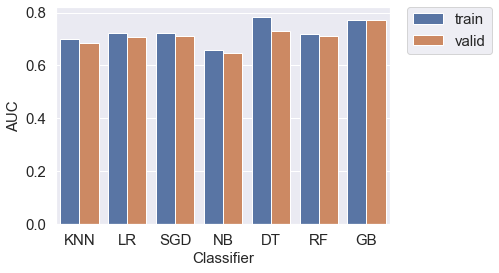

In [117]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

### Learning Curve
To diagnose how the model is doing by plotting a learning curve. Use learning curve code from scikit-learn's website and chance plotting AUC instead of accuracy. 

In [118]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

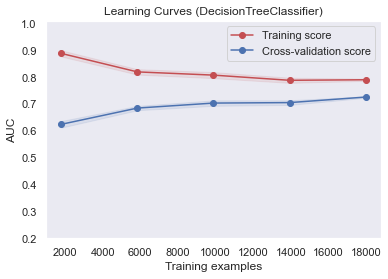

In [120]:
title = "Learning Curves (DecisionTreeClassifier)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = DecisionTreeClassifier(max_depth = 10, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

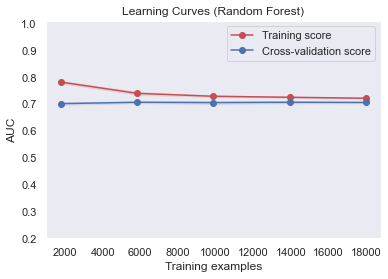

In [119]:
title = "Learning Curves (GradientBoostingClassifier)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In the DecisionTreeClassifier, the training scores are higher than the validation scores, indicating overfitting. In the GradientBoostingClassifier, the training and validation scores are similar but slighly low, which may indicate high bias and underfitting. 

Depending on your learning curve, there are a few strategies you can employ to improve your models

High Bias:

- Add new features
- Increase model complexity
- Reduce regularization
- Change model architecture

High Variance:
- Add more samples 
- Add regularization
- Reduce number of features
- Decrease model complexity
- Add better features
- Change model architecture

## Feature Importance
One way to improve the model is to understand what features are important to the model. This analysis can help to:
- inspire new feature ideas --> helps with both high bias and high variance
- obtain a list of the top features to be used for feature reduction --> helps with high variance
- point out errors in your pipeline --> helps with robustness of model

**Logistic Regression: features**

Note: must have normalized data in order for the coefficients to be comparable between variables. Extract the coefficients using `coef_` and store in a new dataframe (sorted by importance). 

In [121]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [122]:
feature_importances.head()

,importance
AGE,0.319212
PLACE_OF_SERVICE_21,0.255449
PLACE_OF_SERVICE_22,0.161782
CCS_code_35.0,0.107407
PLACE_OF_SERVICE_23,0.095904


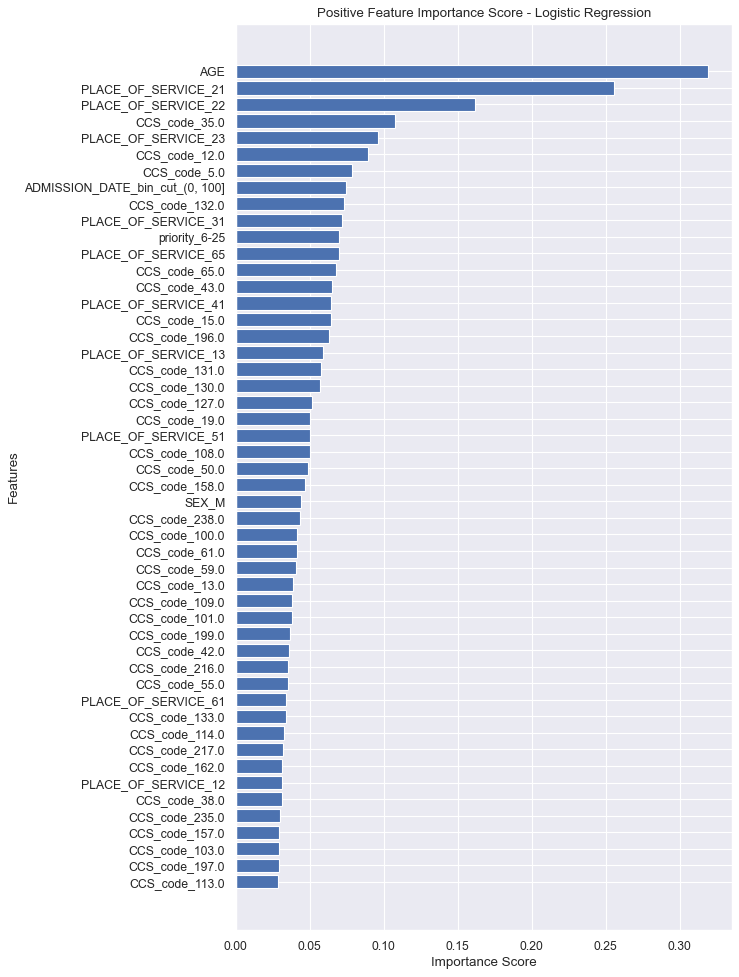

In [123]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

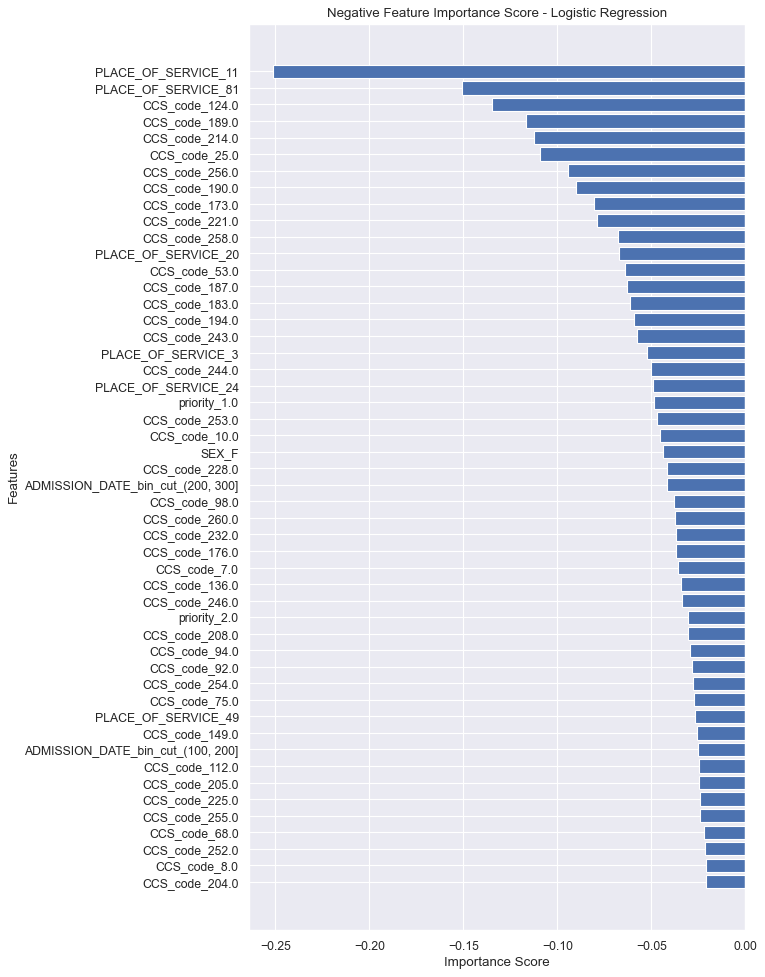

In [124]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

For logistic regression, the variables with highest positive coefficients are predictive of hospitalization and the variables with highest negative coefficients are predictive of not being hospitalized. 

**Random Forest: features**

Note: feature importance in random forests show how often a feature is used to split the data. (no correlation between positive or negative class)

In [125]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [126]:
feature_importances.head()

,importance
PLACE_OF_SERVICE_11,0.154149
PLACE_OF_SERVICE_21,0.147830
AGE,0.105088
priority_6-25,0.089588
PLACE_OF_SERVICE_81,0.074855


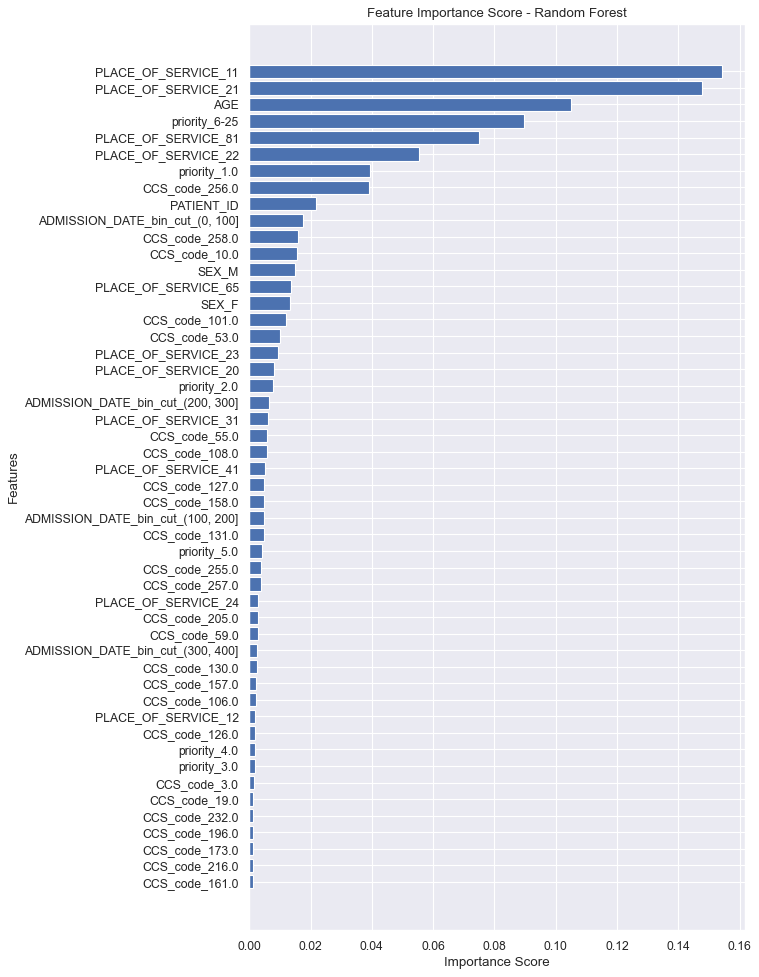

In [127]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

## Hyperparameter tuning

Only optimize hyperparameters for gradient boost because this baseline model performed the best. 

In [132]:
import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

# number of trees
n_estimators = range(100,500,100)
# maximum depth of the tree
max_depth = range(1,5,1)
# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid
random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc,
                                n_iter = 20, cv = 2, scoring=auc_scoring,
                                verbose = 0, random_state = 42)

t1 = time.time()
gbc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

248.31298685073853


In [133]:
gbc_random.best_params_

{'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1}

In [140]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Baseline gbc')
gbc_train_auc_base = roc_auc_score(y_train, y_train_preds)
gbc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(gbc_train_auc_base))
print('Validation AUC:%.3f'%(gbc_valid_auc_base))

print(" ")
print('Optimized gbc')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
gbc_train_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(gbc_train_auc))
print('Validation AUC:%.3f'%(gbc_valid_auc))

Baseline gbc
Training AUC:0.835
Validation AUC:0.771
 
Optimized gbc
Training AUC:0.784
Validation AUC:0.744


Well, it looks like the baseline Gradient Boost Classifier model performed the best. Save the classifier so we don't have to retrain every time we want to run new predictions. 

In [141]:
# save the best classifier 
pickle.dump(gbc, open('best_classifier.pkl', 'wb'),protocol = 4)

# Model Evaluation
Evaluate performance of the best model on the test set.

In [142]:
X_test = df_test[col2use].values
y_test = df_test['HAS_ADMISSION'].values

scaler = pickle.load(open('scaler.sav', 'rb'))
X_test_tf = scaler.transform(X_test)

In [143]:
best_model = pickle.load(open('best_classifier.pkl','rb'))

In [144]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

In [145]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.835
accuracy:0.748
recall:0.755
precision:0.745
specificity:0.742
prevalence:0.500
 
Validation:
AUC:0.771
accuracy:0.696
recall:0.713
precision:0.304
specificity:0.693
prevalence:0.158
 
Test:
AUC:0.765
accuracy:0.694
recall:0.702
precision:0.302
specificity:0.693
prevalence:0.159
 


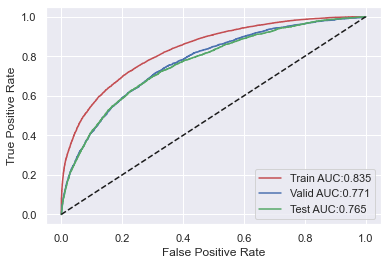

In [146]:
from sklearn.metrics import roc_curve 

# ROC AUC 
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

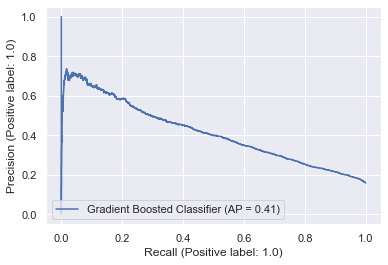

In [155]:
# precision-recall curve AUC
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(gbc, X_test_tf, y_test, name = 'Gradient Boosted Classifier')

# Wrap up 
In this assignment, created a binary classifier to predict the probability that a patient will have a hopsital admission in the next 180 days. On the test data, the best model had an AUC of 0.765 with accuracy of 0.694. The recall is 0.702 with this model, which means that we are able to catch 70% of the readmissions -- the model performs approximately 1.4 times better than randomly selecting patients. 


Due to limited compute power, the model was trained, validated, and tested on only 100,000 rows (as opposed to the 9.5+ million rows available). In addition, I initially intended to group by Patient IDs in order to create a dataframe where each row represents each individual patient (and all their respective datapoints). However, due to limited compute power, I was unable to run this line of code. As next steps, I would recommend modeling with this dataframe. 

**References**
- https://towardsdatascience.com/predicting-hospital-readmission-for-patients-with-diabetes-using-scikit-learn-a2e359b15f0
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
- https://learnopencv.com/bias-variance-tradeoff-in-machine-learning/